# Hessian/Covariance Calculation in Minuit (with internal transforms)

tldr: At the minimum hessians transform under change of variable covariantly

This is a short notebook discussing how Minuit computes covariances and Hessians.

Minuit uses a parameter transformation to map a bounded variable to an unbounded one: $x\in[a,b]\to n\in[-\infty, \infty]$

where the transform is from e$x$ternal variabels to i$n$ternal variables is given by 

$$n(x) = \arcsin\left(2\frac{(x-a)}{b-a} - 1\right)$$

with the inverse being

$$x(n) = a+ \frac{(b-a)}{2}\sin(n) + 1$$




In [144]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def to_bounded(n,bounds):
    a,b = bounds
    return a+0.5*(b-a)*(jnp.sin(n) + 1)

def to_inf(x,bounds):
    a,b = bounds
    return jnp.arcsin(2*(x-a)/(b-a)-1)

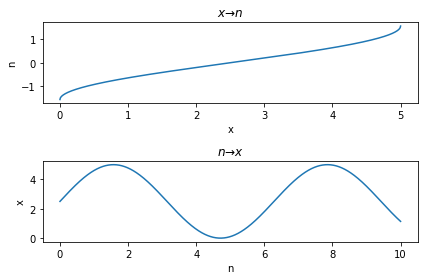

In [145]:
def plot_trfs():
    bounds = [0,5]

    f,axarr = plt.subplots(2,1)

    x = jnp.linspace(bounds[0],bounds[1],1001)
    n = jax.vmap(to_inf,in_axes=(0,None))(x,bounds)
    ax = axarr[0]
    ax.plot(x,n)
    ax.set_xlabel('x')
    ax.set_ylabel('n')
    ax.set_title(r'$x \to n$')

    n = jnp.linspace(0,10,1001)
    x = jax.vmap(to_bounded,in_axes=(0,None))(n,bounds)

    ax = axarr[1]
    ax.plot(n,x)
    ax.set_xlabel('n')
    ax.set_ylabel('x')
    ax.set_title(r'$n \to x$')
    f.set_tight_layout(True)
plot_trfs()

In [575]:
def func(external_pars):
    x,y = external_pars
    z = (x-2)**2 + (y-2)**2
    return z

def internal_func(internal_pars,bounds):
    external_pars = jax.vmap(to_bounded)(internal_pars,bounds)
    return func(external_pars)

def plot_func(ax,func,slices,bounds = None):
    grid = x,y = np.mgrid[slices[0],slices[1]]
    X = jnp.swapaxes(grid,0,-1).reshape(-1,2)

    if bounds is not None:
        Z = jax.vmap(func,in_axes=(0,None))(X,bounds)
    else:
        Z = jax.vmap(func)(X)
    z = jnp.swapaxes(Z.reshape(101,101),0,-1)
    ax.contourf(x,y,z,levels = 100)
    ax.contour(x,y,z,levels = 10, colors = 'w')
    ax.set_xlabel(r'$n_1$')
    ax.set_xlabel(r'$n_2$')
    if bounds is not None:
        rect = patches.Rectangle([-np.pi/2,-np.pi/2],np.pi,np.pi, alpha = 0.2, facecolor = 'k')
        ax.add_patch(rect)
    f.set_size_inches(5,5)

def angle_and_lam(M):
    lam,bases = jnp.linalg.eig(M)
    angle = -jnp.arccos(bases[0,0])*180/np.pi
    return lam,angle

def draw_covariances(ax,func,slices,bounds = None,scale = 1):
    grid = x,y = np.mgrid[slices[0],slices[1]]
    X = np.swapaxes(grid,0,-1).reshape(-1,2)

    if bounds is not None:
        covariance = lambda X,bounds: jnp.linalg.inv(jax.hessian(func)(X,bounds))
        args = (X,bounds)
        axes = (0,None)
    else:
        covariance = lambda X: jnp.linalg.inv(jax.hessian(func)(X))
        args = (X,)
        axes = (0,)
    lams,angles = jax.vmap(angle_and_lam)(jax.vmap(covariance,in_axes=axes)(*args))
    for i,(lam,angle) in enumerate(zip(lams,angles)):
        e = patches.Ellipse(
            X[i],lam[0]*scale,lam[1]*scale,angle,
            alpha = 0.5,
            facecolor = 'none',
            edgecolor = 'k'
        )
        ax.add_patch(e)
    ax.set_xlim(slices[0].start,slices[0].stop)
    ax.set_ylim(slices[0].start,slices[0].stop)    


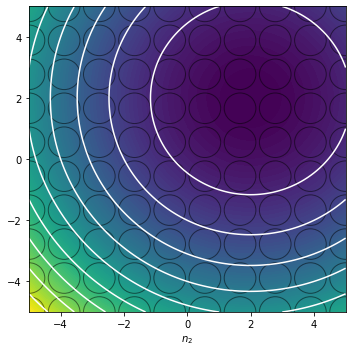

In [576]:
f,ax = plt.subplots(1,1)
f.set_size_inches(5,5)
f.set_tight_layout(True)
plot_func(ax, func, slices = [
        slice(-5,5,101*1j),
        slice(-5,5,101*1j)
    ])

draw_covariances(ax,func,slices = [
        slice(-5,5,10*1j),
        slice(-5,5,10*1j)
    ],
    scale = 2
)    

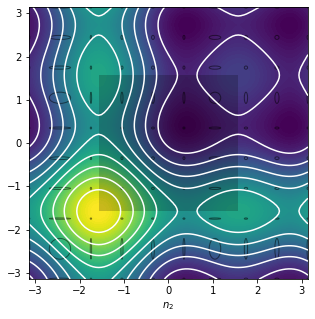

In [592]:
f,ax = plt.subplots(1,1)
f.set_size_inches(5,5)

plot_func(ax,internal_func,slices = [
        slice(-np.pi,np.pi,101*1j),
        slice(-np.pi,np.pi,101*1j)
    ],bounds = bounds)
bounds = jnp.array([[-5,5],[-5,5]])
draw_covariances(ax,internal_func,slices = [
        slice(-np.pi,np.pi,10*1j),
        slice(-np.pi,np.pi,10*1j)
    ],
    bounds = bounds,
    scale = 2
)


# A 1-dimensional example

Applying the chain rule

$$\frac{\partial}{\partial x} \to \frac{\partial y}{\partial x}\frac{\partial}{\partial y}$$

we can transform a second derivative $$\frac{\partial^2}{\partial x^2} f$$

as follows:

$$
\begin{align}
\frac{\partial^2}{\partial x^2} f &= \frac{\partial}{\partial x}\left(\frac{\partial}{\partial x}\left(f \right) \right)\\
\frac{\partial^2}{\partial x^2} f &= \left(\frac{\partial y}{\partial x}\frac{\partial}{\partial y}\right) \left(\frac{\partial y}{\partial x}\frac{\partial}{\partial y}\left(f \right) \right)\\
\frac{\partial^2}{\partial x^2} f &= \left(\frac{\partial y}{\partial x}\right) \left(( \frac{\partial}{\partial y} \frac{\partial y}{\partial x})\frac{\partial f}{\partial y} + \frac{\partial y}{\partial x} ( \frac{\partial}{\partial y} \frac{\partial f}{\partial y} ) \right)\\
 \frac{\partial^2}{\partial x^2} f &= \frac{\partial y}{\partial x}  \frac{\partial^2 y}{\partial y \partial x} \frac{\partial f}{\partial y} + \frac{\partial y}{\partial x} \frac{\partial y}{\partial x} \frac{\partial^2 f}{\partial y \partial y}
\end{align}
$$

So in general, the hessian in the internal and external coordinates are not linearly related.

However at the minimum in the internal coordinates, where the gradient vanishes $\frac{\partial f}{\partial y} = 0$




So at the minimum we have:

$$\frac{\partial^2}{\partial x^2} f |_{\frac{\partial f}{\partial y} = 0} = \frac{\partial y}{\partial x} \frac{\partial y}{\partial x} \frac{\partial^2 f}{\partial y \partial y}$$

The covariance matrix being the inverse of the Hessian matrix, in 1-D this means


$$\mathrm{cov}_{xx} = \frac{\partial x}{\partial y} \frac{\partial x}{\partial y} \mathrm{cov}_{yy}$$


# Full Matrix Example

$$
\begin{align}
\frac{\partial^2}{\partial x_i \partial x_j} f &= \frac{\partial}{\partial x_i}\left(\frac{\partial}{\partial x_j}\left(f \right) \right)\\
\end{align}
$$

under a Jacobian transform

$$\frac{\partial}{\partial x_i} \to \sum_k \frac{\partial y_k}{\partial x_i}\frac{\partial}{\partial y_k} = J_{ik} \frac{\partial}{\partial y_k}$$ 


$$
\begin{align}
\frac{\partial^2}{\partial x_i \partial x_j} f &= \frac{\partial}{\partial x_i}\left(\frac{\partial}{\partial x_j}\left(f \right) \right)\\
\frac{\partial^2}{\partial x_i \partial x_j} f &= J_{ik}\frac{\partial}{\partial y_k}\left(J_{jl}\frac{\partial}{\partial y_l}\left(f \right) \right)\\
\frac{\partial^2}{\partial x_i \partial x_j} f &= J_{ik}\left( \frac{\partial}{\partial y_k}( J_{jl} )\frac{\partial}{\partial y_l}\left(f \right) + J_{jl} \frac{\partial}{\partial y_k} \frac{\partial}{\partial y_l}\left(f \right) \right)\\
\frac{\partial^2}{\partial x_i \partial x_j} f &= J_{ik}(\frac{\partial}{\partial y_k}J_{jl})\frac{\partial f}{\partial y_l} + J_{ik} J_{jl}  \frac{\partial^2 f}{\partial y_k \partial y_l} \\
\end{align}
$$

at the minimum, where $\frac{\partial f}{\partial y_l} = 0$

we have

$$\frac{\partial^2}{\partial x_i \partial x_j} f |_{\frac{\partial f}{\partial y_l} = 0} = J_{ik} J_{jl}  \frac{\partial^2 f}{\partial y_k \partial y_l} $$


since we have element-wise transforms $J_{ik}  = g_i \delta_{ik} = \frac{\partial y_i}{\partial x_i}$ and thus 

$$\frac{\partial^2}{\partial x_i \partial x_j} f |_{\frac{\partial f}{\partial y_l} = 0} = g_{i}  \frac{\partial^2 f}{\partial y_i \partial y_j} g_{j} $$


and with the inverse being $(A B C)^{-1}$ = C^{-1}B^{-1} A^{-1}$ we get 

$$\mathrm{cov}_{x_i,x_j} =  \frac{\partial x_j}{\partial y_j}  \cdot \mathrm{cov}_{y_i,y_j} \cdot    \frac{\partial x_i}{\partial y_i}$$


as is computed here: 

https://root.cern.ch/doc/master/classROOT_1_1Minuit2_1_1MnUserTransformation.html#a10f2146be0a2c991243dd2f70a943a15

In [491]:
def grads_from_n(n):
    x = jax.vmap(to_bounded)(n,bounds)
    J = jax.jacfwd(jax.vmap(to_inf))(x,bounds)
    return J

In [593]:
def hessian_transform(extr,bounds):
    intr = jax.vmap(to_inf)(extr,bounds)

    first = jax.jacfwd(jax.vmap(to_inf))(extr,bounds)  
    secnd = jax.jacfwd(grads_from_n)(intr)
    third = jax.grad(internal_func)(intr,bounds)

    J = jax.jacfwd(jax.vmap(to_inf))(extr,bounds)

    a = jnp.einsum('ik,kjl,l->ij',first,secnd,third)

    int_hessian = jax.hessian(internal_func)(intr,bounds)
    b = jnp.einsum('ik,jl,kl->ij',J,J,int_hessian)
    return int_hessian,a,b,a+b

In [596]:
def compare(ax,scale = 2, index = -1, color = 'k'):
    slices = [slice(-5,5,11j),slice(-5,5,11j)]

    grid = x,y = np.mgrid[slices[0],slices[1]]
    X = np.swapaxes(grid,0,-1).reshape(-1,2)
    covariance = lambda X,bounds: hessian_transform(X,bounds)[index]
    args = (X,bounds)
    axes = (0,None)

    covariances = jax.vmap(covariance,in_axes=axes)(*args)

    lams,angles = jax.vmap(angle_and_lam)(covariances)
    for i,(lam,angle) in enumerate(zip(lams,angles)):
        e = patches.Ellipse(
            X[i],lam[0]*scale,lam[1]*scale,angle,
            alpha = 0.5,
            facecolor = 'none',
            edgecolor = color
        )
        ax.add_patch(e)
    ax.set_xlim(slices[0].start,slices[0].stop)
    ax.set_ylim(slices[0].start,slices[0].stop)        

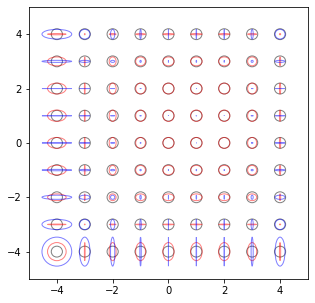

In [603]:
f,ax = plt.subplots(1,1)
compare(ax,scale = 0.2, index = -1)
compare(ax,scale = 0.2, index = -2, color = 'r')
compare(ax,scale = 0.2, index = -3, color = 'b')
plt.gcf().set_size_inches(5,5)